# Phase 1: Frame Extraction Pipeline
## Weakly Supervised Video Anomaly Detection using TimeSformer and MIL

This notebook implements the complete Phase 1 pipeline for extracting frames from the UCF-Crime dataset using **Temporal Dilated Sampling** strategy.

### Pipeline Overview:
1. **Configuration & Setup** - Dataset paths, parameters, and environment setup
2. **Utility Functions** - Video processing, statistics, and visualization helpers
3. **Temporal Dilated Sampler** - Core frame extraction algorithm
4. **Dataset Processor** - Batch processing for UCF-Crime dataset
5. **GPU Acceleration** - NVIDIA GPU support for faster extraction
6. **Testing & Validation** - Verify extraction on sample videos
7. **Full Dataset Processing** - Run extraction on entire dataset

### Key Concepts:
- **Temporal Dilated Sampling**: Divides videos into T segments and samples frames with dilation to capture long-term temporal patterns
- **Frame Normalization**: All frames resized to 224×224 for TimeSformer compatibility
- **UCF-Crime Dataset**: 13 anomaly categories + 1 normal category

## Section 1: Configuration and Setup

This section defines all configuration parameters for the frame extraction pipeline including:
- Dataset paths (UCF-Crime location)
- Frame extraction parameters (number of frames, resolution, dilation factor)
- UCF-Crime category definitions
- Processing parameters

In [ ]:
"""
Configuration for Weakly Supervised Video Anomaly Detection
Phase 1: Dataset & Preprocessing Configuration
"""

import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import json
import logging
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool, cpu_count
import time
import copy
from collections import Counter

# Try to import decord for GPU acceleration
try:
    import decord
    from decord import VideoReader, gpu, cpu
    DECORD_AVAILABLE = True
    print("✓ Decord library available for GPU-accelerated video decoding")
except ImportError:
    DECORD_AVAILABLE = False
    print("✗ Decord not available, falling back to OpenCV (CPU)")

# ==================== Dataset Paths ====================
DATASET_ROOT = r"C:\UCF_video_dataset"
RAW_VIDEOS_PATH = os.path.join(DATASET_ROOT, "Raw_Videos_Unified")
EXTRACTED_FRAMES_PATH = os.path.join(DATASET_ROOT, "Extracted_Frames")

# ==================== UCF-Crime Dataset Categories ====================
# Anomaly Categories (13 classes)
ANOMALY_CATEGORIES = [
    "Abuse",
    "Arrest", 
    "Arson",
    "Assault",
    "Burglary",
    "Explosion",
    "Fighting",
    "RoadAccidents",
    "Robbery",
    "Shooting",
    "Shoplifting",
    "Stealing",
    "Vandalism"
]

# Normal Category
NORMAL_CATEGORY = "Normal"

# All Categories
ALL_CATEGORIES = ANOMALY_CATEGORIES + [NORMAL_CATEGORY]

# ==================== Frame Extraction Parameters ====================
# Number of frames to extract per video (T)
NUM_FRAMES_PER_VIDEO = 32  # TimeSformer typically uses 8-32 frames

# Frame dimensions (for TimeSformer input)
FRAME_HEIGHT = 224
FRAME_WIDTH = 224

# Dilation factor - determines the temporal stride between sampled frames
DILATION_FACTOR = 4

# Sampling strategy options: 'uniform', 'dilated', 'random'
SAMPLING_STRATEGY = 'dilated'

# ==================== Video Processing Parameters ====================
# Supported video formats
VIDEO_EXTENSIONS = ['.mp4', '.avi', '.mkv', '.mov']

# Number of workers for parallel processing
NUM_WORKERS = 4

# Batch size for processing videos
BATCH_SIZE = 8

# ==================== Output Settings ====================
# Save format for extracted frames
FRAME_FORMAT = 'jpg'
FRAME_QUALITY = 95  # JPEG quality (1-100)

# Segments per video for MIL
SEGMENTS_PER_VIDEO = 32

# ==================== Logging ====================
LOG_LEVEL = 'INFO'
LOG_FILE = os.path.join(DATASET_ROOT, 'preprocessing.log')

# ==================== Random Seed ====================
RANDOM_SEED = 42

# Setup logging
logging.basicConfig(
    level=getattr(logging, LOG_LEVEL),
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Print configuration summary
print("\n" + "="*70)
print("CONFIGURATION LOADED")
print("="*70)
print(f"Dataset Root: {DATASET_ROOT}")
print(f"Raw Videos Path: {RAW_VIDEOS_PATH}")
print(f"Extracted Frames Path: {EXTRACTED_FRAMES_PATH}")
print(f"Frames per Video: {NUM_FRAMES_PER_VIDEO}")
print(f"Frame Resolution: {FRAME_HEIGHT}x{FRAME_WIDTH}")
print(f"Sampling Strategy: {SAMPLING_STRATEGY}")
print(f"Dilation Factor: {DILATION_FACTOR}")
print(f"Categories: {len(ALL_CATEGORIES)} ({len(ANOMALY_CATEGORIES)} anomaly + 1 normal)")
print("="*70)

✓ Decord library available for GPU-accelerated video decoding

CONFIGURATION LOADED
Dataset Root: C:\UCF_video_dataset
Raw Videos Path: C:\UCF_video_dataset\Raw_Videos_Unified
Extracted Frames Path: C:\UCF_video_dataset\Extracted_Frames
Frames per Video: 32
Frame Resolution: 224x224
Sampling Strategy: dilated
Dilation Factor: 4
Categories: 14 (13 anomaly + 1 normal)


## Section 2: Utility Functions

Helper functions for:
- Video processing and statistics
- Sampling visualization
- Frame visualization
- Dataset analysis

In [ ]:
"""
Utility Functions for Frame Extraction Pipeline
"""

def visualize_sampling_indices(
    total_frames: int,
    num_samples: int,
    dilation_factor: int,
    save_path: Optional[str] = None
) -> None:
    """
    Visualize different sampling strategies for comparison.
    
    Args:
        total_frames: Total number of frames in video
        num_samples: Number of frames to sample
        dilation_factor: Dilation factor for dilated sampling
        save_path: Path to save the visualization
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 8))
    
    # Uniform sampling
    uniform_indices = np.linspace(0, total_frames - 1, num_samples, dtype=int)
    
    # Dilated sampling
    segment_size = total_frames // num_samples
    effective_dilation = min(dilation_factor, segment_size)
    dilated_indices = []
    for i in range(num_samples):
        seg_start = i * segment_size
        seg_end = min((i + 1) * segment_size, total_frames)
        offset = (i % effective_dilation) * (segment_size // max(effective_dilation, 1))
        frame_idx = seg_start + (offset % (seg_end - seg_start))
        dilated_indices.append(min(frame_idx, total_frames - 1))
    dilated_indices = np.array(dilated_indices)
    
    # Random sampling (for comparison)
    np.random.seed(42)
    random_indices = np.sort(np.random.choice(total_frames, num_samples, replace=False))
    
    # Plot uniform sampling
    axes[0].scatter(uniform_indices, np.ones(num_samples), c='blue', s=50, marker='|')
    axes[0].set_xlim(0, total_frames)
    axes[0].set_title('Uniform Sampling', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Sampled')
    axes[0].axhline(y=1, color='lightgray', linestyle='-', alpha=0.5)
    
    # Plot dilated sampling
    axes[1].scatter(dilated_indices, np.ones(num_samples), c='green', s=50, marker='|')
    axes[1].set_xlim(0, total_frames)
    axes[1].set_title(f'Temporal Dilated Sampling (dilation={dilation_factor})', 
                      fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Sampled')
    axes[1].axhline(y=1, color='lightgray', linestyle='-', alpha=0.5)
    
    # Plot random sampling
    axes[2].scatter(random_indices, np.ones(num_samples), c='red', s=50, marker='|')
    axes[2].set_xlim(0, total_frames)
    axes[2].set_title('Random Sampling', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Frame Index')
    axes[2].set_ylabel('Sampled')
    axes[2].axhline(y=1, color='lightgray', linestyle='-', alpha=0.5)
    
    # Add segment boundaries for dilated sampling
    for i in range(num_samples + 1):
        boundary = i * segment_size
        for ax in axes:
            ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()


def visualize_extracted_frames(
    frame_paths: List[str],
    num_display: int = 8,
    save_path: Optional[str] = None
) -> None:
    """
    Visualize a grid of extracted frames.
    
    Args:
        frame_paths: List of paths to extracted frames
        num_display: Number of frames to display
        save_path: Path to save the visualization
    """
    num_display = min(num_display, len(frame_paths))
    
    # Select frames evenly distributed
    indices = np.linspace(0, len(frame_paths) - 1, num_display, dtype=int)
    selected_paths = [frame_paths[i] for i in indices]
    
    cols = 4
    rows = (num_display + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten() if num_display > 1 else [axes]
    
    for i, (ax, path) in enumerate(zip(axes, selected_paths)):
        frame = cv2.imread(path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax.imshow(frame)
        ax.set_title(f'Frame {indices[i]}', fontsize=10)
        ax.axis('off')
    
    # Hide empty subplots
    for ax in axes[num_display:]:
        ax.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()


def get_video_statistics(video_path: str) -> Dict:
    """
    Get comprehensive statistics for a video file.
    
    Args:
        video_path: Path to the video file
        
    Returns:
        Dictionary containing video statistics
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        return {'error': f'Cannot open video: {video_path}'}
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = total_frames / fps if fps > 0 else 0
    
    # Get codec info
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    codec = "".join([chr((fourcc >> 8 * i) & 0xFF) for i in range(4)])
    
    # Sample a frame to get color info
    ret, frame = cap.read()
    color_channels = frame.shape[2] if ret and len(frame.shape) == 3 else 1
    
    cap.release()
    
    return {
        'path': video_path,
        'filename': os.path.basename(video_path),
        'total_frames': total_frames,
        'fps': round(fps, 2),
        'duration_seconds': round(duration, 2),
        'duration_formatted': f"{int(duration // 60):02d}:{int(duration % 60):02d}",
        'width': width,
        'height': height,
        'aspect_ratio': round(width / height, 2) if height > 0 else 0,
        'codec': codec,
        'color_channels': color_channels,
        'file_size_mb': round(os.path.getsize(video_path) / (1024 * 1024), 2)
    }


def analyze_dataset_statistics(raw_videos_path: str = RAW_VIDEOS_PATH) -> Dict:
    """
    Analyze statistics across the entire dataset.
    
    Args:
        raw_videos_path: Path to raw videos directory
        
    Returns:
        Dictionary containing dataset-wide statistics
    """
    stats = {
        'categories': {},
        'total_videos': 0,
        'total_frames': 0,
        'total_duration_hours': 0,
        'anomaly_videos': 0,
        'normal_videos': 0,
        'fps_distribution': [],
        'duration_distribution': [],
        'resolution_distribution': []
    }
    
    for category in ALL_CATEGORIES:
        category_path = os.path.join(raw_videos_path, category)
        
        if not os.path.exists(category_path):
            continue
        
        category_stats = {
            'videos': [],
            'total_frames': 0,
            'total_duration': 0,
            'min_duration': float('inf'),
            'max_duration': 0
        }
        
        video_files = [f for f in os.listdir(category_path) 
                       if any(f.lower().endswith(ext) for ext in VIDEO_EXTENSIONS)]
        
        for video_file in tqdm(video_files, desc=f"Analyzing {category}", leave=False):
            video_path = os.path.join(category_path, video_file)
            video_stats = get_video_statistics(video_path)
            
            if 'error' not in video_stats:
                category_stats['videos'].append(video_stats)
                category_stats['total_frames'] += video_stats['total_frames']
                category_stats['total_duration'] += video_stats['duration_seconds']
                category_stats['min_duration'] = min(category_stats['min_duration'], 
                                                     video_stats['duration_seconds'])
                category_stats['max_duration'] = max(category_stats['max_duration'], 
                                                     video_stats['duration_seconds'])
                
                stats['fps_distribution'].append(video_stats['fps'])
                stats['duration_distribution'].append(video_stats['duration_seconds'])
                stats['resolution_distribution'].append(f"{video_stats['width']}x{video_stats['height']}")
        
        category_stats['num_videos'] = len(category_stats['videos'])
        category_stats['avg_duration'] = (category_stats['total_duration'] / 
                                          category_stats['num_videos'] 
                                          if category_stats['num_videos'] > 0 else 0)
        category_stats['is_anomaly'] = category != NORMAL_CATEGORY
        
        stats['categories'][category] = category_stats
        stats['total_videos'] += category_stats['num_videos']
        stats['total_frames'] += category_stats['total_frames']
        stats['total_duration_hours'] += category_stats['total_duration'] / 3600
        
        if category_stats['is_anomaly']:
            stats['anomaly_videos'] += category_stats['num_videos']
        else:
            stats['normal_videos'] += category_stats['num_videos']
    
    return stats


def print_dataset_analysis(stats: Dict) -> None:
    """
    Print a formatted analysis of dataset statistics.
    
    Args:
        stats: Dictionary containing dataset statistics
    """
    print("\n" + "="*70)
    print("UCF-CRIME DATASET ANALYSIS")
    print("="*70)
    
    print(f"\nOverall Statistics:")
    print("-"*40)
    print(f"  Total Videos: {stats['total_videos']}")
    print(f"  Total Frames: {stats['total_frames']:,}")
    print(f"  Total Duration: {stats['total_duration_hours']:.2f} hours")
    print(f"  Anomaly Videos: {stats['anomaly_videos']}")
    print(f"  Normal Videos: {stats['normal_videos']}")
    
    print(f"\nPer-Category Statistics:")
    print("-"*70)
    print(f"{'Category':<20} {'Videos':>8} {'Frames':>12} {'Avg Dur':>10} {'Type':>10}")
    print("-"*70)
    
    for category, cat_stats in stats['categories'].items():
        cat_type = "ANOMALY" if cat_stats['is_anomaly'] else "NORMAL"
        print(f"{category:<20} {cat_stats['num_videos']:>8} "
              f"{cat_stats['total_frames']:>12,} "
              f"{cat_stats['avg_duration']:>10.1f}s "
              f"{cat_type:>10}")
    
    print("-"*70)
    
    # FPS distribution
    if stats['fps_distribution']:
        fps_values = stats['fps_distribution']
        print(f"\nFPS Distribution:")
        print(f"  Min: {min(fps_values):.1f}, Max: {max(fps_values):.1f}, "
              f"Mean: {np.mean(fps_values):.1f}")
    
    # Duration distribution
    if stats['duration_distribution']:
        dur_values = stats['duration_distribution']
        print(f"\nDuration Distribution (seconds):")
        print(f"  Min: {min(dur_values):.1f}, Max: {max(dur_values):.1f}, "
              f"Mean: {np.mean(dur_values):.1f}")
    
    # Resolution distribution
    if stats['resolution_distribution']:
        res_counts = Counter(stats['resolution_distribution'])
        print(f"\nTop Resolutions:")
        for res, count in res_counts.most_common(5):
            print(f"  {res}: {count} videos")
    
    print("\n" + "="*70)


def create_train_test_split(
    metadata_path: str,
    train_ratio: float = 0.8,
    seed: int = RANDOM_SEED
) -> Tuple[List[Dict], List[Dict]]:
    """
    Create train/test split from extracted frames metadata.
    
    Args:
        metadata_path: Path to dataset_metadata.json
        train_ratio: Ratio of data for training
        seed: Random seed for reproducibility
        
    Returns:
        Tuple of (train_videos, test_videos) lists
    """
    np.random.seed(seed)
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    train_videos = []
    test_videos = []
    
    for category, cat_info in metadata['categories'].items():
        successful_videos = [v for v in cat_info['videos'] if v['status'] == 'success']
        
        # Shuffle videos
        np.random.shuffle(successful_videos)
        
        # Split
        split_idx = int(len(successful_videos) * train_ratio)
        train_videos.extend(successful_videos[:split_idx])
        test_videos.extend(successful_videos[split_idx:])
    
    # Shuffle final lists
    np.random.shuffle(train_videos)
    np.random.shuffle(test_videos)
    
    print(f"Train/Test Split:")
    print(f"  Training videos: {len(train_videos)}")
    print(f"  Testing videos: {len(test_videos)}")
    
    return train_videos, test_videos


print("✓ Utility functions loaded successfully")

✓ Utility functions loaded successfully


## Section 3: Temporal Dilated Sampling Implementation

The **Temporal Dilated Sampling** strategy is key to capturing long-term temporal patterns in videos:

1. **Divide video into T segments** (T = 32 by default)
2. **Apply dilation within each segment** to spread out sampling
3. **Sample one frame per segment** with varying offsets based on dilation factor

This approach captures more temporal context than uniform sampling while maintaining a fixed output size.

In [ ]:
class TemporalDilatedSampler:
    """
    Implements Temporal Dilated Sampling for frame extraction.
    
    The strategy divides each video into T segments and samples one frame
    from each segment, creating a temporally-aware representation of the
    entire video while maintaining a fixed output size.
    """
    
    def __init__(
        self,
        num_frames: int = NUM_FRAMES_PER_VIDEO,
        frame_height: int = FRAME_HEIGHT,
        frame_width: int = FRAME_WIDTH,
        dilation_factor: int = DILATION_FACTOR,
        sampling_strategy: str = SAMPLING_STRATEGY
    ):
        """
        Initialize the Temporal Dilated Sampler.
        
        Args:
            num_frames: Number of frames to extract per video (T)
            frame_height: Height to resize frames to
            frame_width: Width to resize frames to
            dilation_factor: Temporal dilation factor for sampling
            sampling_strategy: 'uniform', 'dilated', or 'random'
        """
        self.num_frames = num_frames
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.dilation_factor = dilation_factor
        self.sampling_strategy = sampling_strategy
        
        logger.info(f"Initialized TemporalDilatedSampler with T={num_frames}, "
                   f"resolution={frame_height}x{frame_width}, "
                   f"dilation={dilation_factor}, strategy={sampling_strategy}")
    
    def get_video_info(self, video_path: str) -> Dict:
        """
        Get video metadata including frame count, FPS, and duration.
        
        Args:
            video_path: Path to the video file
            
        Returns:
            Dictionary containing video metadata
        """
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        duration = total_frames / fps if fps > 0 else 0
        
        cap.release()
        
        return {
            'total_frames': total_frames,
            'fps': fps,
            'width': width,
            'height': height,
            'duration': duration,
            'path': video_path
        }
    
    def compute_sampling_indices(self, total_frames: int) -> np.ndarray:
        """
        Compute the frame indices to sample based on the selected strategy.
        
        Temporal Dilated Sampling Strategy:
        - Divide video into T segments
        - Apply dilation within each segment to spread out sampling
        - This captures longer temporal context than uniform sampling
        
        Args:
            total_frames: Total number of frames in the video
            
        Returns:
            Array of frame indices to extract
        """
        if total_frames < self.num_frames:
            # If video has fewer frames than requested, sample with replacement
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
            logger.warning(f"Video has only {total_frames} frames, "
                         f"sampling with repetition to get {self.num_frames} frames")
            return indices
        
        if self.sampling_strategy == 'uniform':
            # Uniform sampling: evenly spaced frames across the video
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
            
        elif self.sampling_strategy == 'dilated':
            # Temporal Dilated Sampling
            segment_size = total_frames // self.num_frames
            effective_dilation = min(self.dilation_factor, segment_size)
            
            indices = []
            for i in range(self.num_frames):
                seg_start = i * segment_size
                seg_end = min((i + 1) * segment_size, total_frames)
                
                # Apply dilation: sample with dilation offset
                center = (seg_start + seg_end) // 2
                offset = (i % effective_dilation) * (segment_size // max(effective_dilation, 1))
                
                # Ensure index is within segment bounds
                frame_idx = seg_start + (offset % (seg_end - seg_start))
                indices.append(min(frame_idx, total_frames - 1))
            
            indices = np.array(indices, dtype=int)
            
        elif self.sampling_strategy == 'random':
            # Random sampling within segments (useful for data augmentation)
            np.random.seed(RANDOM_SEED)
            segment_size = total_frames // self.num_frames
            
            indices = []
            for i in range(self.num_frames):
                seg_start = i * segment_size
                seg_end = min((i + 1) * segment_size, total_frames)
                frame_idx = np.random.randint(seg_start, seg_end)
                indices.append(frame_idx)
            
            indices = np.array(indices, dtype=int)
        
        else:
            raise ValueError(f"Unknown sampling strategy: {self.sampling_strategy}")
        
        return indices
    
    def extract_frames(
        self,
        video_path: str,
        output_dir: Optional[str] = None,
        save_frames: bool = True
    ) -> Tuple[np.ndarray, List[str]]:
        """
        Extract frames from a video using temporal dilated sampling.
        
        Args:
            video_path: Path to the video file
            output_dir: Directory to save extracted frames (if save_frames=True)
            save_frames: Whether to save frames to disk
            
        Returns:
            Tuple of (frames array, list of saved frame paths)
        """
        # Get video info
        video_info = self.get_video_info(video_path)
        total_frames = video_info['total_frames']
        
        # Compute sampling indices
        indices = self.compute_sampling_indices(total_frames)
        
        # Open video
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")
        
        frames = []
        saved_paths = []
        
        # Extract video name for frame naming
        video_name = Path(video_path).stem
        
        for frame_num, idx in enumerate(indices):
            # Set frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if not ret:
                logger.warning(f"Could not read frame {idx} from {video_path}")
                # Use black frame as fallback
                frame = np.zeros((self.frame_height, self.frame_width, 3), dtype=np.uint8)
            else:
                # Resize frame
                frame = cv2.resize(frame, (self.frame_width, self.frame_height))
                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            frames.append(frame)
            
            # Save frame if requested
            if save_frames and output_dir:
                os.makedirs(output_dir, exist_ok=True)
                frame_filename = f"{video_name}_frame_{frame_num:04d}.{FRAME_FORMAT}"
                frame_path = os.path.join(output_dir, frame_filename)
                
                # Convert back to BGR for saving with OpenCV
                frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                
                if FRAME_FORMAT.lower() == 'jpg':
                    cv2.imwrite(frame_path, frame_bgr, 
                              [cv2.IMWRITE_JPEG_QUALITY, FRAME_QUALITY])
                else:
                    cv2.imwrite(frame_path, frame_bgr)
                
                saved_paths.append(frame_path)
        
        cap.release()
        
        frames_array = np.stack(frames, axis=0)  # Shape: (T, H, W, C)
        
        return frames_array, saved_paths


print("✓ TemporalDilatedSampler class loaded successfully")

✓ TemporalDilatedSampler class loaded successfully


## Section 4: UCF-Crime Dataset Processor

Handles batch processing of the entire UCF-Crime dataset:
- Directory structure management
- Parallel video processing with ThreadPoolExecutor
- Progress tracking and logging
- Metadata generation for downstream tasks

In [ ]:
class UCFCrimeDatasetProcessor:
    """
    Processes the entire UCF-Crime dataset for frame extraction.
    
    Handles:
    - Directory structure management
    - Parallel video processing
    - Progress tracking and logging
    - Metadata generation
    """
    
    def __init__(
        self,
        raw_videos_path: str = RAW_VIDEOS_PATH,
        output_path: str = EXTRACTED_FRAMES_PATH,
        num_workers: int = NUM_WORKERS
    ):
        """
        Initialize the dataset processor.
        
        Args:
            raw_videos_path: Path to raw videos directory
            output_path: Path to save extracted frames
            num_workers: Number of parallel workers
        """
        self.raw_videos_path = raw_videos_path
        self.output_path = output_path
        self.num_workers = num_workers
        
        self.sampler = TemporalDilatedSampler()
        
        # Initialize metadata storage
        self.metadata = {
            'categories': {},
            'total_videos': 0,
            'total_frames': 0,
            'anomaly_videos': 0,
            'normal_videos': 0,
            'config': {
                'num_frames_per_video': NUM_FRAMES_PER_VIDEO,
                'frame_height': FRAME_HEIGHT,
                'frame_width': FRAME_WIDTH,
                'sampling_strategy': SAMPLING_STRATEGY,
                'dilation_factor': DILATION_FACTOR
            }
        }
        
        logger.info(f"Initialized UCFCrimeDatasetProcessor")
        logger.info(f"Raw videos path: {raw_videos_path}")
        logger.info(f"Output path: {output_path}")
    
    def discover_videos(self) -> Dict[str, List[str]]:
        """
        Discover all videos in the dataset organized by category.
        
        Returns:
            Dictionary mapping category names to list of video paths
        """
        videos_by_category = {}
        
        for category in ALL_CATEGORIES:
            category_path = os.path.join(self.raw_videos_path, category)
            
            if not os.path.exists(category_path):
                logger.warning(f"Category directory not found: {category_path}")
                continue
            
            videos = []
            for file in os.listdir(category_path):
                if any(file.lower().endswith(ext) for ext in VIDEO_EXTENSIONS):
                    videos.append(os.path.join(category_path, file))
            
            videos_by_category[category] = sorted(videos)
            logger.info(f"Found {len(videos)} videos in category: {category}")
        
        return videos_by_category
    
    def process_single_video(
        self,
        video_path: str,
        category: str
    ) -> Dict:
        """
        Process a single video: extract frames and generate metadata.
        
        Args:
            video_path: Path to the video file
            category: Category of the video
            
        Returns:
            Dictionary containing processing results
        """
        video_name = Path(video_path).stem
        
        # Create output directory for this video's frames
        output_dir = os.path.join(self.output_path, category, video_name)
        
        try:
            # Get video info
            video_info = self.sampler.get_video_info(video_path)
            
            # Extract frames
            frames, saved_paths = self.sampler.extract_frames(
                video_path,
                output_dir=output_dir,
                save_frames=True
            )
            
            result = {
                'video_name': video_name,
                'video_path': video_path,
                'category': category,
                'is_anomaly': category != NORMAL_CATEGORY,
                'total_video_frames': video_info['total_frames'],
                'extracted_frames': len(saved_paths),
                'frame_paths': saved_paths,
                'fps': video_info['fps'],
                'duration': video_info['duration'],
                'original_resolution': f"{video_info['width']}x{video_info['height']}",
                'status': 'success'
            }
            
            logger.debug(f"Successfully processed: {video_name}")
            
        except Exception as e:
            result = {
                'video_name': video_name,
                'video_path': video_path,
                'category': category,
                'status': 'failed',
                'error': str(e)
            }
            logger.error(f"Failed to process {video_name}: {str(e)}")
        
        return result
    
    def process_dataset(self, categories: Optional[List[str]] = None) -> Dict:
        """
        Process the entire dataset or specified categories.
        
        Args:
            categories: List of categories to process (None for all)
            
        Returns:
            Complete metadata dictionary
        """
        # Discover videos
        videos_by_category = self.discover_videos()
        
        # Filter categories if specified
        if categories:
            videos_by_category = {
                k: v for k, v in videos_by_category.items() 
                if k in categories
            }
        
        # Create output directory
        os.makedirs(self.output_path, exist_ok=True)
        
        all_results = []
        
        # Process each category
        for category, video_paths in videos_by_category.items():
            logger.info(f"\n{'='*60}")
            logger.info(f"Processing category: {category} ({len(video_paths)} videos)")
            logger.info('='*60)
            
            category_results = []
            
            # Process videos with progress bar
            pbar = tqdm(video_paths, desc=f"Processing {category}", unit="video")
            
            if self.num_workers > 1:
                # Parallel processing
                with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                    futures = {
                        executor.submit(self.process_single_video, vp, category): vp
                        for vp in video_paths
                    }
                    
                    for future in as_completed(futures):
                        result = future.result()
                        category_results.append(result)
                        pbar.update(1)
            else:
                # Sequential processing
                for video_path in pbar:
                    result = self.process_single_video(video_path, category)
                    category_results.append(result)
            
            pbar.close()
            
            # Store category metadata
            successful = [r for r in category_results if r['status'] == 'success']
            failed = [r for r in category_results if r['status'] == 'failed']
            
            self.metadata['categories'][category] = {
                'total_videos': len(video_paths),
                'successful': len(successful),
                'failed': len(failed),
                'is_anomaly': category != NORMAL_CATEGORY,
                'videos': category_results
            }
            
            all_results.extend(category_results)
            
            logger.info(f"Category {category}: {len(successful)}/{len(video_paths)} videos processed successfully")
        
        # Update global metadata
        successful_results = [r for r in all_results if r['status'] == 'success']
        self.metadata['total_videos'] = len(all_results)
        self.metadata['successful_videos'] = len(successful_results)
        self.metadata['total_frames'] = sum(
            r.get('extracted_frames', 0) for r in successful_results
        )
        self.metadata['anomaly_videos'] = sum(
            1 for r in successful_results if r.get('is_anomaly', False)
        )
        self.metadata['normal_videos'] = sum(
            1 for r in successful_results if not r.get('is_anomaly', True)
        )
        
        # Save metadata
        self.save_metadata()
        
        return self.metadata
    
    def save_metadata(self, filename: str = 'dataset_metadata.json'):
        """
        Save dataset metadata to a JSON file.
        
        Args:
            filename: Name of the metadata file
        """
        metadata_path = os.path.join(self.output_path, filename)
        
        # Create a serializable version of metadata
        def convert_to_serializable(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        serializable_metadata = copy.deepcopy(self.metadata)
        
        with open(metadata_path, 'w') as f:
            json.dump(serializable_metadata, f, indent=2, default=convert_to_serializable)
        
        logger.info(f"Metadata saved to: {metadata_path}")
    
    def print_summary(self):
        """Print a summary of the processed dataset."""
        print("\n" + "="*70)
        print("DATASET PROCESSING SUMMARY")
        print("="*70)
        print(f"\nTotal Videos: {self.metadata.get('total_videos', 0)}")
        print(f"Successfully Processed: {self.metadata.get('successful_videos', 0)}")
        print(f"Total Frames Extracted: {self.metadata.get('total_frames', 0)}")
        print(f"Anomaly Videos: {self.metadata.get('anomaly_videos', 0)}")
        print(f"Normal Videos: {self.metadata.get('normal_videos', 0)}")
        
        print("\nPer-Category Breakdown:")
        print("-"*50)
        for category, info in self.metadata.get('categories', {}).items():
            status = "ANOMALY" if info.get('is_anomaly', False) else "NORMAL"
            print(f"  {category:20s} [{status:8s}]: "
                  f"{info.get('successful', 0)}/{info.get('total_videos', 0)} videos")
        
        print("\nConfiguration:")
        print("-"*50)
        config_info = self.metadata.get('config', {})
        print(f"  Frames per video: {config_info.get('num_frames_per_video', 'N/A')}")
        print(f"  Frame resolution: {config_info.get('frame_height', 'N/A')}x"
              f"{config_info.get('frame_width', 'N/A')}")
        print(f"  Sampling strategy: {config_info.get('sampling_strategy', 'N/A')}")
        print(f"  Dilation factor: {config_info.get('dilation_factor', 'N/A')}")
        print("="*70 + "\n")


print("✓ UCFCrimeDatasetProcessor class loaded successfully")

✓ UCFCrimeDatasetProcessor class loaded successfully


## Section 5: GPU-Accelerated Frame Extraction

For faster processing on NVIDIA GPUs (like RTX 3080 Ti), this section provides GPU-accelerated frame extraction using the **decord** library with NVDEC hardware decoding.

Features:
- GPU-accelerated video decoding
- Multi-processing for parallel video processing
- Resume capability (skips already processed videos)
- Automatic fallback to CPU if GPU unavailable

In [ ]:
def check_gpu_availability():
    """Check if CUDA GPU is available for decord."""
    if not DECORD_AVAILABLE:
        return False, "Decord library not installed"
    
    try:
        decord.bridge.set_bridge('native')
        ctx = gpu(0)
        return True, "NVIDIA GPU available for video decoding"
    except Exception as e:
        return False, f"GPU not available: {str(e)}"


class GPUFrameExtractor:
    """
    GPU-accelerated frame extractor using decord library.
    Falls back to OpenCV if GPU is not available.
    """
    
    def __init__(
        self,
        num_frames: int = NUM_FRAMES_PER_VIDEO,
        frame_height: int = FRAME_HEIGHT,
        frame_width: int = FRAME_WIDTH,
        use_gpu: bool = True
    ):
        self.num_frames = num_frames
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.use_gpu = use_gpu and DECORD_AVAILABLE
        
        # Check GPU availability
        if self.use_gpu:
            gpu_available, msg = check_gpu_availability()
            self.use_gpu = gpu_available
            logger.info(msg)
        
        if self.use_gpu:
            decord.bridge.set_bridge('native')
            self.ctx = gpu(0)
            logger.info("Using GPU (NVDEC) for video decoding")
        else:
            self.ctx = cpu(0) if DECORD_AVAILABLE else None
            logger.info("Using CPU for video decoding")
    
    def compute_sampling_indices(self, total_frames: int) -> np.ndarray:
        """Compute temporal dilated sampling indices."""
        if total_frames < self.num_frames:
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
            return indices
        
        # Temporal Dilated Sampling
        segment_size = total_frames // self.num_frames
        dilation = min(DILATION_FACTOR, segment_size)
        
        indices = []
        for i in range(self.num_frames):
            seg_start = i * segment_size
            seg_end = min((i + 1) * segment_size, total_frames)
            offset = (i % dilation) * (segment_size // max(dilation, 1))
            frame_idx = seg_start + (offset % (seg_end - seg_start))
            indices.append(min(frame_idx, total_frames - 1))
        
        return np.array(indices, dtype=int)
    
    def extract_frames_gpu(self, video_path: str) -> Tuple[np.ndarray, int]:
        """Extract frames using GPU-accelerated decord."""
        try:
            vr = VideoReader(video_path, ctx=self.ctx)
            total_frames = len(vr)
            
            indices = self.compute_sampling_indices(total_frames)
            
            # Batch read frames (GPU accelerated)
            frames = vr.get_batch(indices).asnumpy()  # Shape: (T, H, W, C) in RGB
            
            # Resize frames
            resized_frames = []
            for frame in frames:
                resized = cv2.resize(frame, (self.frame_width, self.frame_height))
                resized_frames.append(resized)
            
            return np.stack(resized_frames, axis=0), total_frames
            
        except Exception as e:
            logger.warning(f"GPU extraction failed for {video_path}: {e}, falling back to CPU")
            return self.extract_frames_cpu(video_path)
    
    def extract_frames_cpu(self, video_path: str) -> Tuple[np.ndarray, int]:
        """Extract frames using OpenCV (CPU)."""
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = self.compute_sampling_indices(total_frames)
        
        frames = []
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if not ret:
                frame = np.zeros((self.frame_height, self.frame_width, 3), dtype=np.uint8)
            else:
                frame = cv2.resize(frame, (self.frame_width, self.frame_height))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            frames.append(frame)
        
        cap.release()
        return np.stack(frames, axis=0), total_frames
    
    def extract_and_save(self, video_path: str, output_dir: str) -> Dict:
        """Extract frames and save to disk."""
        video_name = Path(video_path).stem
        os.makedirs(output_dir, exist_ok=True)
        
        try:
            start_time = time.time()
            
            # Extract frames
            if self.use_gpu and DECORD_AVAILABLE:
                frames, total_frames = self.extract_frames_gpu(video_path)
            else:
                frames, total_frames = self.extract_frames_cpu(video_path)
            
            # Save frames
            saved_paths = []
            for i, frame in enumerate(frames):
                frame_path = os.path.join(output_dir, f"{video_name}_frame_{i:04d}.jpg")
                frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                cv2.imwrite(frame_path, frame_bgr, [cv2.IMWRITE_JPEG_QUALITY, FRAME_QUALITY])
                saved_paths.append(frame_path)
            
            elapsed = time.time() - start_time
            
            return {
                'video_name': video_name,
                'video_path': video_path,
                'total_video_frames': total_frames,
                'extracted_frames': len(saved_paths),
                'frame_paths': saved_paths,
                'processing_time': round(elapsed, 2),
                'status': 'success'
            }
            
        except Exception as e:
            return {
                'video_name': video_name,
                'video_path': video_path,
                'status': 'failed',
                'error': str(e)
            }


def process_single_video_gpu(args):
    """Process a single video (for multiprocessing)."""
    video_path, category, output_base_path, use_gpu = args
    video_name = Path(video_path).stem
    output_dir = os.path.join(output_base_path, category, video_name)
    
    # Check if already processed (resume capability)
    expected_frames = NUM_FRAMES_PER_VIDEO
    if os.path.exists(output_dir):
        existing_frames = len([f for f in os.listdir(output_dir) if f.endswith('.jpg')])
        if existing_frames >= expected_frames:
            return {
                'video_name': video_name,
                'category': category,
                'status': 'skipped',
                'reason': 'already processed'
            }
    
    extractor = GPUFrameExtractor(use_gpu=use_gpu)
    result = extractor.extract_and_save(video_path, output_dir)
    result['category'] = category
    result['is_anomaly'] = category != NORMAL_CATEGORY
    
    return result


def run_gpu_extraction(
    use_gpu: bool = True,
    num_workers: int = None,
    categories: List[str] = None,
    resume: bool = True
):
    """
    Run frame extraction on the entire dataset with GPU acceleration.
    
    Args:
        use_gpu: Whether to use GPU acceleration
        num_workers: Number of parallel workers (default: CPU count)
        categories: Specific categories to process (None for all)
        resume: Skip already processed videos
    """
    print("\n" + "="*70)
    print("GPU-ACCELERATED FRAME EXTRACTION")
    print("="*70)
    
    # Check GPU status
    gpu_available, gpu_msg = check_gpu_availability()
    print(f"\nGPU Status: {gpu_msg}")
    
    if use_gpu and not gpu_available:
        print("⚠ GPU requested but not available, using CPU")
        use_gpu = False
    
    # Determine number of workers
    if num_workers is None:
        if use_gpu:
            num_workers = min(4, cpu_count())
        else:
            num_workers = min(8, cpu_count())
    
    print(f"Workers: {num_workers}")
    print(f"Using GPU: {use_gpu}")
    
    # Discover videos
    videos_to_process = []
    categories_to_process = categories or ALL_CATEGORIES
    
    print("\nDiscovering videos...")
    for category in categories_to_process:
        category_path = os.path.join(RAW_VIDEOS_PATH, category)
        if not os.path.exists(category_path):
            continue
        
        for video_file in os.listdir(category_path):
            if any(video_file.lower().endswith(ext) for ext in VIDEO_EXTENSIONS):
                video_path = os.path.join(category_path, video_file)
                videos_to_process.append((
                    video_path,
                    category,
                    EXTRACTED_FRAMES_PATH,
                    use_gpu
                ))
    
    total_videos = len(videos_to_process)
    print(f"Total videos to process: {total_videos}")
    
    # Estimate time
    est_time_per_video = 1.5 if use_gpu else 3.0
    est_total_time = (total_videos * est_time_per_video) / num_workers
    print(f"\nEstimated time: {est_total_time/60:.1f} minutes ({est_total_time/3600:.2f} hours)")
    
    # Create output directory
    os.makedirs(EXTRACTED_FRAMES_PATH, exist_ok=True)
    
    # Process videos
    start_time = time.time()
    results = []
    successful = 0
    failed = 0
    skipped = 0
    
    print("\nStarting extraction...\n")
    
    # Use ThreadPoolExecutor instead of multiprocessing.Pool for Windows compatibility
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        pbar = tqdm(total=total_videos, desc="Extracting frames", unit="video")
        
        # Submit all tasks
        futures = {
            executor.submit(process_single_video_gpu, args): args 
            for args in videos_to_process
        }
        
        # Process results as they complete
        for future in as_completed(futures):
            result = future.result()
            results.append(result)
            
            if result['status'] == 'success':
                successful += 1
            elif result['status'] == 'failed':
                failed += 1
                logger.error(f"Failed: {result.get('video_name', 'unknown')} - {result.get('error', 'unknown error')}")
            elif result['status'] == 'skipped':
                skipped += 1
            
            pbar.update(1)
            pbar.set_postfix({'success': successful, 'failed': failed, 'skipped': skipped})
        pbar.close()
    
    elapsed_time = time.time() - start_time
    
    # Save metadata
    metadata = {
        'total_videos': total_videos,
        'successful': successful,
        'failed': failed,
        'skipped': skipped,
        'processing_time_seconds': round(elapsed_time, 2),
        'processing_time_minutes': round(elapsed_time / 60, 2),
        'used_gpu': use_gpu,
        'num_workers': num_workers,
        'config': {
            'num_frames_per_video': NUM_FRAMES_PER_VIDEO,
            'frame_height': FRAME_HEIGHT,
            'frame_width': FRAME_WIDTH,
            'sampling_strategy': SAMPLING_STRATEGY
        },
        'videos': results
    }
    
    metadata_path = os.path.join(EXTRACTED_FRAMES_PATH, 'extraction_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    # Print summary
    print("\n" + "="*70)
    print("EXTRACTION COMPLETE!")
    print("="*70)
    print(f"\nResults:")
    print(f"  Total videos: {total_videos}")
    print(f"  Successful: {successful}")
    print(f"  Failed: {failed}")
    print(f"  Skipped (already done): {skipped}")
    print(f"\nTime elapsed: {elapsed_time/60:.2f} minutes ({elapsed_time:.0f} seconds)")
    print(f"Average per video: {elapsed_time/max(successful,1):.2f} seconds")
    print(f"\nFrames extracted: {successful * NUM_FRAMES_PER_VIDEO:,}")
    print(f"Output directory: {EXTRACTED_FRAMES_PATH}")
    print(f"Metadata saved to: {metadata_path}")
    print("="*70)
    
    return metadata


print("✓ GPU-Accelerated Frame Extraction classes loaded successfully")

✓ GPU-Accelerated Frame Extraction classes loaded successfully


## Section 6: Testing Functions

Test the frame extraction pipeline on sample videos before processing the entire dataset.

In [ ]:
def test_dataset_discovery():
    """Test the video discovery functionality."""
    print("\n" + "="*60)
    print("TESTING DATASET DISCOVERY")
    print("="*60)
    
    processor = UCFCrimeDatasetProcessor()
    videos_by_category = processor.discover_videos()
    
    print("\n--- Discovered Videos ---")
    total = 0
    for category, videos in videos_by_category.items():
        print(f"  {category}: {len(videos)} videos")
        total += len(videos)
    
    print(f"\n  Total videos discovered: {total}")
    print("="*60)
    
    return videos_by_category


def test_single_video():
    """Test frame extraction on a single video."""
    print("="*60)
    print("TESTING FRAME EXTRACTION ON A SINGLE VIDEO")
    print("="*60)
    
    # Find a test video
    test_category = "Abuse"
    test_video_dir = os.path.join(RAW_VIDEOS_PATH, test_category)
    
    if not os.path.exists(test_video_dir):
        print(f"Test directory not found: {test_video_dir}")
        return None, None
    
    video_files = [f for f in os.listdir(test_video_dir) 
                   if f.endswith('.mp4')]
    
    if not video_files:
        print("No video files found for testing")
        return None, None
    
    test_video_path = os.path.join(test_video_dir, video_files[0])
    print(f"\nTest video: {test_video_path}")
    
    # Initialize sampler
    sampler = TemporalDilatedSampler(
        num_frames=NUM_FRAMES_PER_VIDEO,
        frame_height=FRAME_HEIGHT,
        frame_width=FRAME_WIDTH,
        dilation_factor=DILATION_FACTOR,
        sampling_strategy=SAMPLING_STRATEGY
    )
    
    # Get video info
    print("\n--- Video Information ---")
    video_info = sampler.get_video_info(test_video_path)
    for key, value in video_info.items():
        print(f"  {key}: {value}")
    
    # Compute sampling indices
    print("\n--- Sampling Indices ---")
    indices = sampler.compute_sampling_indices(video_info['total_frames'])
    print(f"  Total video frames: {video_info['total_frames']}")
    print(f"  Number of samples: {len(indices)}")
    print(f"  First 10 indices: {indices[:10].tolist()}")
    print(f"  Last 10 indices: {indices[-10:].tolist()}")
    
    # Extract frames
    print("\n--- Extracting Frames ---")
    output_dir = os.path.join(EXTRACTED_FRAMES_PATH, "test_output")
    frames, saved_paths = sampler.extract_frames(
        test_video_path,
        output_dir=output_dir,
        save_frames=True
    )
    
    print(f"  Extracted frames shape: {frames.shape}")
    print(f"  Saved {len(saved_paths)} frames to: {output_dir}")
    
    if saved_paths:
        print(f"\n  Sample saved paths:")
        for path in saved_paths[:3]:
            print(f"    - {path}")
    
    print("\n" + "="*60)
    print("TEST COMPLETED SUCCESSFULLY!")
    print("="*60)
    
    return frames, saved_paths


print("✓ Testing functions loaded successfully")

✓ Testing functions loaded successfully


## Section 7: Visualization - Sampling Strategies

Visualize the different sampling strategies to understand how Temporal Dilated Sampling works.

Visualizing different sampling strategies...
This shows how Temporal Dilated Sampling captures more varied temporal patterns.



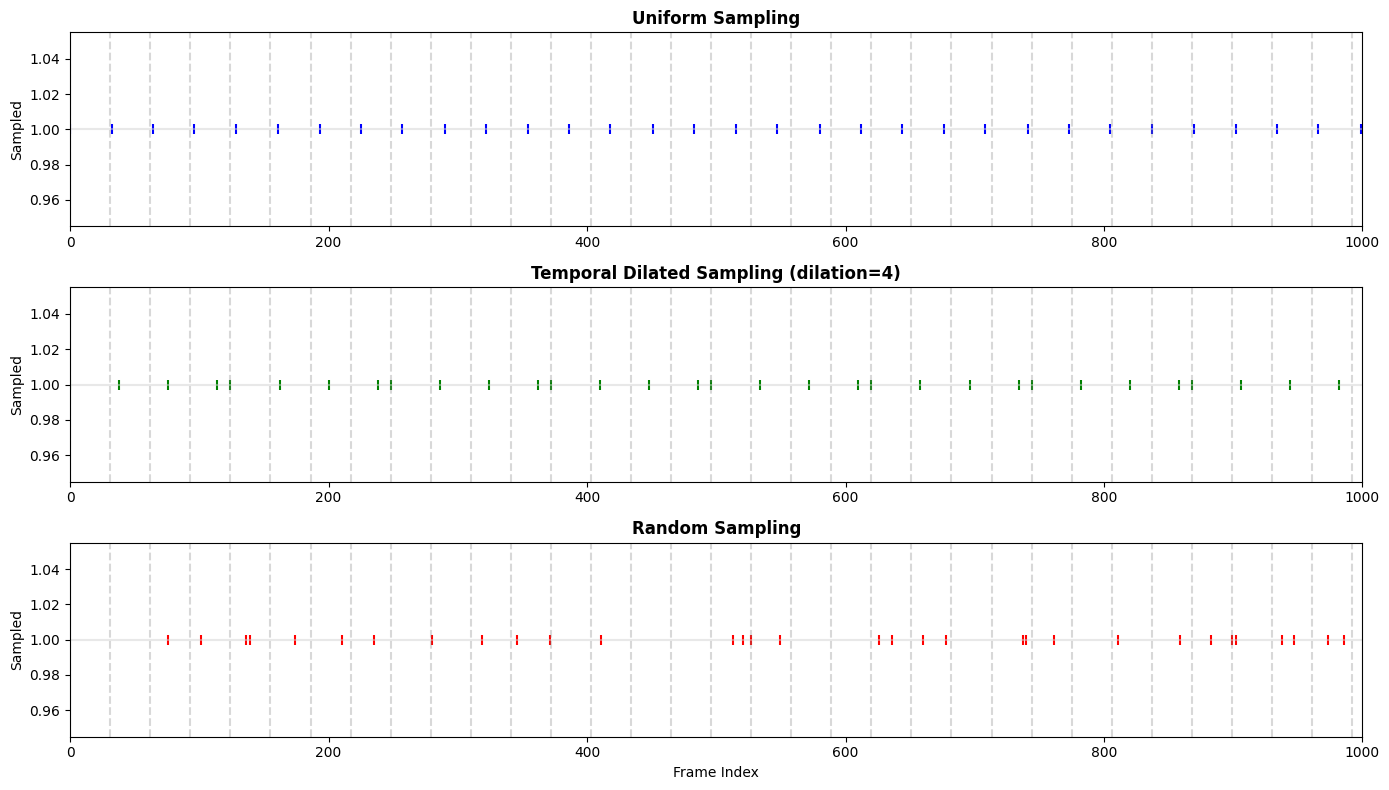

In [ ]:
# Visualize sampling strategies for a video with 1000 frames
print("Visualizing different sampling strategies...")
print("This shows how Temporal Dilated Sampling captures more varied temporal patterns.\n")

visualize_sampling_indices(
    total_frames=1000,
    num_samples=32,
    dilation_factor=4,
    save_path=None  # Set to a path to save the figure
)

## Section 8: Run Tests

Run the testing functions to verify the pipeline works correctly.

In [ ]:
# Test dataset discovery
videos_by_category = test_dataset_discovery()

2026-01-20 17:27:42,886 - INFO - Initialized TemporalDilatedSampler with T=32, resolution=224x224, dilation=4, strategy=dilated
2026-01-20 17:27:42,888 - INFO - Initialized UCFCrimeDatasetProcessor
2026-01-20 17:27:42,888 - INFO - Raw videos path: C:\UCF_video_dataset\Raw_Videos_Unified
2026-01-20 17:27:42,889 - INFO - Output path: C:\UCF_video_dataset\Extracted_Frames
2026-01-20 17:27:42,890 - INFO - Found 50 videos in category: Abuse
2026-01-20 17:27:42,891 - INFO - Found 50 videos in category: Arrest
2026-01-20 17:27:42,892 - INFO - Found 50 videos in category: Arson
2026-01-20 17:27:42,893 - INFO - Found 50 videos in category: Assault
2026-01-20 17:27:42,895 - INFO - Found 100 videos in category: Burglary
2026-01-20 17:27:42,895 - INFO - Found 50 videos in category: Explosion
2026-01-20 17:27:42,897 - INFO - Found 50 videos in category: Fighting
2026-01-20 17:27:42,897 - INFO - Found 150 videos in category: RoadAccidents
2026-01-20 17:27:42,904 - INFO - Found 150 videos in category


TESTING DATASET DISCOVERY

--- Discovered Videos ---
  Abuse: 50 videos
  Arrest: 50 videos
  Arson: 50 videos
  Assault: 50 videos
  Burglary: 100 videos
  Explosion: 50 videos
  Fighting: 50 videos
  RoadAccidents: 150 videos
  Robbery: 150 videos
  Shooting: 50 videos
  Shoplifting: 50 videos
  Stealing: 100 videos
  Vandalism: 50 videos
  Normal: 950 videos

  Total videos discovered: 1900


2026-01-20 17:27:42,921 - INFO - Initialized TemporalDilatedSampler with T=32, resolution=224x224, dilation=4, strategy=dilated


TESTING FRAME EXTRACTION ON A SINGLE VIDEO

Test video: C:\UCF_video_dataset\Raw_Videos_Unified\Abuse\Abuse001_x264.mp4

--- Video Information ---
  total_frames: 2729
  fps: 30.0
  width: 320
  height: 240
  duration: 90.96666666666667
  path: C:\UCF_video_dataset\Raw_Videos_Unified\Abuse\Abuse001_x264.mp4

--- Sampling Indices ---
  Total video frames: 2729
  Number of samples: 32
  First 10 indices: [0, 106, 212, 318, 340, 446, 552, 658, 680, 786]
  Last 10 indices: [1912, 2018, 2040, 2146, 2252, 2358, 2380, 2486, 2592, 2698]

--- Extracting Frames ---
  Extracted frames shape: (32, 224, 224, 3)
  Saved 32 frames to: C:\UCF_video_dataset\Extracted_Frames\test_output

  Sample saved paths:
    - C:\UCF_video_dataset\Extracted_Frames\test_output\Abuse001_x264_frame_0000.jpg
    - C:\UCF_video_dataset\Extracted_Frames\test_output\Abuse001_x264_frame_0001.jpg
    - C:\UCF_video_dataset\Extracted_Frames\test_output\Abuse001_x264_frame_0002.jpg

TEST COMPLETED SUCCESSFULLY!

Visualizing e

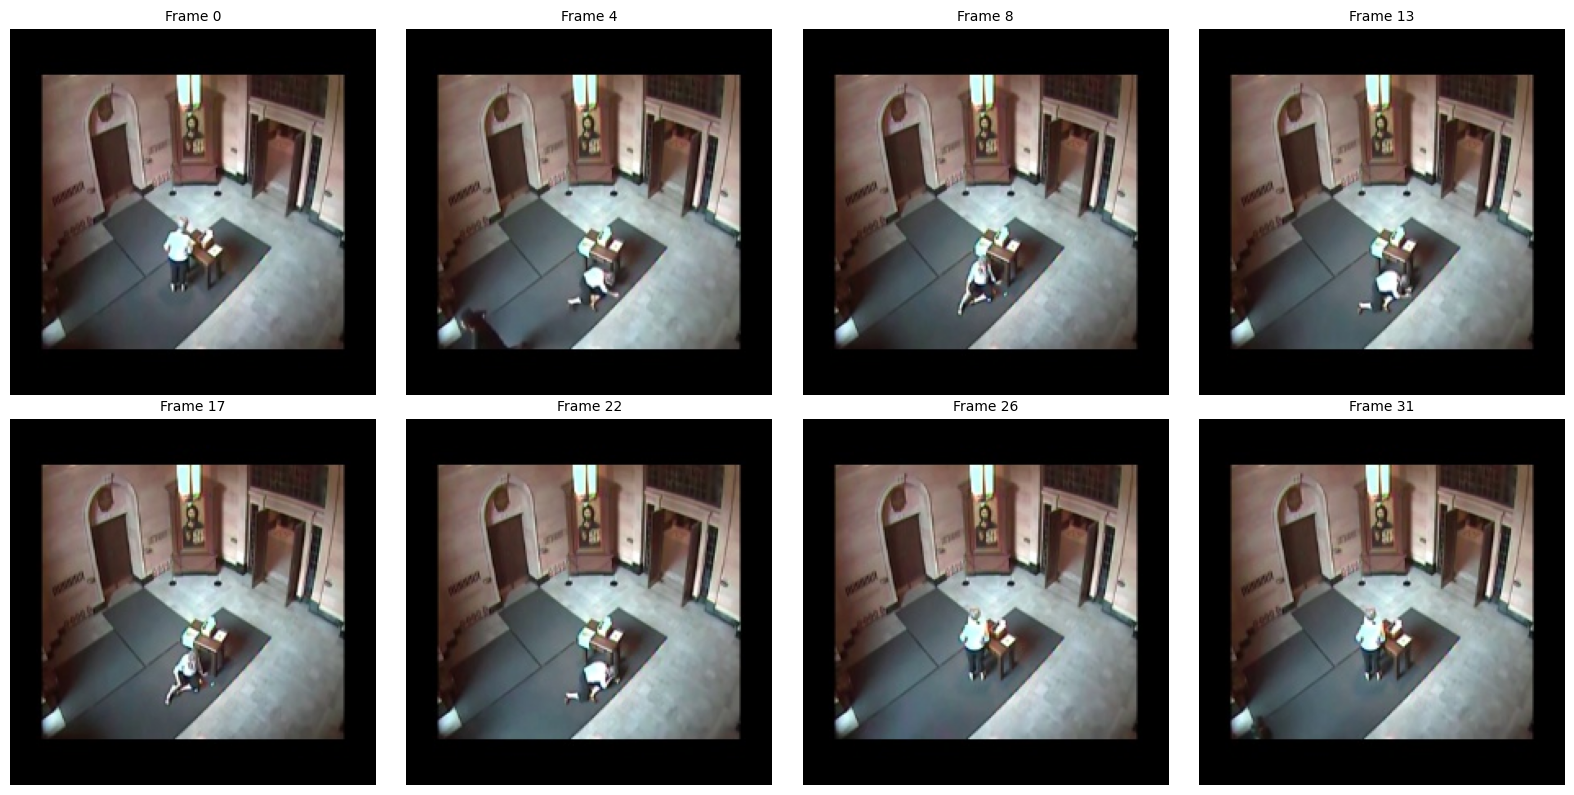

In [ ]:
# Test single video extraction
frames, saved_paths = test_single_video()

# Visualize extracted frames if available
if saved_paths:
    print("\nVisualizing extracted frames...")
    visualize_extracted_frames(saved_paths, num_display=8)

## Section 9: Dataset Analysis

Analyze the entire UCF-Crime dataset to understand its statistics before processing.

In [ ]:
# Analyze dataset statistics (this may take a few minutes for the full dataset)
print("Analyzing UCF-Crime dataset statistics...")
print("This will scan all videos to gather statistics.\n")

# Uncomment to run full analysis (takes a few minutes)
# stats = analyze_dataset_statistics()
# print_dataset_analysis(stats)

# Quick category check
processor = UCFCrimeDatasetProcessor()
videos_by_category = processor.discover_videos()

print("\n--- Dataset Overview ---")
total = 0
for category, videos in videos_by_category.items():
    is_anomaly = category != NORMAL_CATEGORY
    label = "ANOMALY" if is_anomaly else "NORMAL"
    print(f"  {category:20s} [{label:8s}]: {len(videos):4d} videos")
    total += len(videos)
print(f"\n  {'TOTAL':20s}: {total:14d} videos")
print(f"  Anomaly Categories: {len(ANOMALY_CATEGORIES)}")
print(f"  Normal Categories: 1")

2026-01-20 17:27:43,885 - INFO - Initialized TemporalDilatedSampler with T=32, resolution=224x224, dilation=4, strategy=dilated
2026-01-20 17:27:43,886 - INFO - Initialized UCFCrimeDatasetProcessor
2026-01-20 17:27:43,886 - INFO - Raw videos path: C:\UCF_video_dataset\Raw_Videos_Unified
2026-01-20 17:27:43,886 - INFO - Output path: C:\UCF_video_dataset\Extracted_Frames
2026-01-20 17:27:43,887 - INFO - Found 50 videos in category: Abuse
2026-01-20 17:27:43,888 - INFO - Found 50 videos in category: Arrest
2026-01-20 17:27:43,888 - INFO - Found 50 videos in category: Arson
2026-01-20 17:27:43,888 - INFO - Found 50 videos in category: Assault
2026-01-20 17:27:43,892 - INFO - Found 100 videos in category: Burglary
2026-01-20 17:27:43,893 - INFO - Found 50 videos in category: Explosion
2026-01-20 17:27:43,893 - INFO - Found 50 videos in category: Fighting
2026-01-20 17:27:43,899 - INFO - Found 150 videos in category: RoadAccidents
2026-01-20 17:27:43,902 - INFO - Found 150 videos in category

Analyzing UCF-Crime dataset statistics...
This will scan all videos to gather statistics.


--- Dataset Overview ---
  Abuse                [ANOMALY ]:   50 videos
  Arrest               [ANOMALY ]:   50 videos
  Arson                [ANOMALY ]:   50 videos
  Assault              [ANOMALY ]:   50 videos
  Burglary             [ANOMALY ]:  100 videos
  Explosion            [ANOMALY ]:   50 videos
  Fighting             [ANOMALY ]:   50 videos
  RoadAccidents        [ANOMALY ]:  150 videos
  Robbery              [ANOMALY ]:  150 videos
  Shooting             [ANOMALY ]:   50 videos
  Shoplifting          [ANOMALY ]:   50 videos
  Stealing             [ANOMALY ]:  100 videos
  Vandalism            [ANOMALY ]:   50 videos
  Normal               [NORMAL  ]:  950 videos

  TOTAL               :           1900 videos
  Anomaly Categories: 13
  Normal Categories: 1


## Section 10: Full Dataset Processing

Run the complete frame extraction pipeline on the UCF-Crime dataset.

**Options:**
1. **CPU Processing** - Uses OpenCV (slower but works everywhere)
2. **GPU Processing** - Uses decord with NVDEC (faster, requires NVIDIA GPU)
3. **Specific Categories** - Process only selected categories

In [ ]:
# Option 1: Process specific categories (for testing)
# Uncomment and run to process specific categories

# specific_categories = ["Abuse", "Normal"]
# processor = UCFCrimeDatasetProcessor(num_workers=4)
# metadata = processor.process_dataset(categories=specific_categories)
# processor.print_summary()

print("To process specific categories, uncomment the code above.")

To process specific categories, uncomment the code above.


In [ ]:
# Option 2: Process entire dataset with CPU (Standard method)
# Uncomment and run to process all categories

# processor = UCFCrimeDatasetProcessor(num_workers=4)
# metadata = processor.process_dataset()
# processor.print_summary()

print("To process the entire dataset with CPU, uncomment the code above.")

To process the entire dataset with CPU, uncomment the code above.


In [ ]:
# Option 3: Process entire dataset with GPU acceleration (Recommended for NVIDIA GPUs)
# Using 1 worker for GPU - NVDEC handles parallelism internally

metadata = run_gpu_extraction(
    use_gpu=True,          # Use GPU if available
    num_workers=1,         # Use 1 worker for GPU (NVDEC is already fast, multiple workers cause contention)
    categories=None,       # None = all categories, or specify list like ["Abuse", "Normal"]
    resume=True            # Skip already processed videos
)

print("\nNote: GPU extraction uses 1 worker because NVDEC handles decoding efficiently.")
print("Multiple workers compete for GPU access and actually slow things down.")


GPU-ACCELERATED FRAME EXTRACTION

GPU Status: NVIDIA GPU available for video decoding
Workers: 1
Using GPU: True

Discovering videos...
Total videos to process: 1900

Estimated time: 47.5 minutes (0.79 hours)

Starting extraction...



Extracting frames:   0%|          | 0/1900 [00:00<?, ?video/s]


EXTRACTION COMPLETE!

Results:
  Total videos: 1900
  Successful: 0
  Failed: 0
  Skipped (already done): 1900

Time elapsed: 0.02 minutes (1 seconds)
Average per video: 1.37 seconds

Frames extracted: 0
Output directory: C:\UCF_video_dataset\Extracted_Frames
Metadata saved to: C:\UCF_video_dataset\Extracted_Frames\extraction_metadata.json

Note: GPU extraction uses 1 worker because NVDEC handles decoding efficiently.
Multiple workers compete for GPU access and actually slow things down.


## Section 11: Post-Processing - Train/Test Split

After extraction is complete, create train/test splits for model training.

In [ ]:
# Create train/test split after extraction is complete
# This handles both metadata formats (from UCFCrimeDatasetProcessor or GPU extraction)

def create_train_test_split_flexible(
    extracted_frames_path: str = EXTRACTED_FRAMES_PATH,
    train_ratio: float = 0.8,
    seed: int = RANDOM_SEED
) -> Tuple[List[Dict], List[Dict]]:
    """
    Create train/test split from extracted frames metadata.
    Handles both metadata formats (dataset_metadata.json and extraction_metadata.json).
    
    Args:
        extracted_frames_path: Path to extracted frames directory
        train_ratio: Ratio of data for training
        seed: Random seed for reproducibility
        
    Returns:
        Tuple of (train_videos, test_videos) lists
    """
    np.random.seed(seed)
    
    # Try to find metadata file (check both possible names)
    metadata_path = os.path.join(extracted_frames_path, 'dataset_metadata.json')
    extraction_metadata_path = os.path.join(extracted_frames_path, 'extraction_metadata.json')
    
    metadata = None
    metadata_format = None
    
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        metadata_format = 'processor'
        print(f"✓ Found metadata: {metadata_path}")
    elif os.path.exists(extraction_metadata_path):
        with open(extraction_metadata_path, 'r') as f:
            metadata = json.load(f)
        metadata_format = 'gpu_extraction'
        print(f"✓ Found metadata: {extraction_metadata_path}")
    else:
        print(f"✗ No metadata file found!")
        print(f"  Checked: {metadata_path}")
        print(f"  Checked: {extraction_metadata_path}")
        print("  Please run the frame extraction first.")
        return [], []
    
    # Collect successful videos based on metadata format
    videos_by_category = {}
    
    if metadata_format == 'processor':
        # UCFCrimeDatasetProcessor format: categories -> videos
        for category, cat_info in metadata.get('categories', {}).items():
            successful_videos = [v for v in cat_info.get('videos', []) if v.get('status') == 'success']
            for v in successful_videos:
                v['category'] = category
                v['is_anomaly'] = category != NORMAL_CATEGORY
            if category not in videos_by_category:
                videos_by_category[category] = []
            videos_by_category[category].extend(successful_videos)
    
    elif metadata_format == 'gpu_extraction':
        # GPU extraction format: flat videos list
        for video in metadata.get('videos', []):
            if video.get('status') in ['success', 'skipped']:
                category = video.get('category', 'Unknown')
                video['is_anomaly'] = category != NORMAL_CATEGORY
                if category not in videos_by_category:
                    videos_by_category[category] = []
                videos_by_category[category].append(video)
    
    train_videos = []
    test_videos = []
    
    print("\nSplitting by category to maintain class balance:")
    print("-" * 50)
    
    for category, videos in sorted(videos_by_category.items()):
        # Shuffle videos within category
        videos_copy = videos.copy()
        np.random.shuffle(videos_copy)
        
        # Split
        split_idx = int(len(videos_copy) * train_ratio)
        cat_train = videos_copy[:split_idx]
        cat_test = videos_copy[split_idx:]
        
        train_videos.extend(cat_train)
        test_videos.extend(cat_test)
        
        print(f"  {category:20s}: {len(cat_train):4d} train, {len(cat_test):4d} test")
    
    # Shuffle final lists
    np.random.shuffle(train_videos)
    np.random.shuffle(test_videos)
    
    print("-" * 50)
    print(f"\nTrain/Test Split Summary:")
    print(f"  Training videos:  {len(train_videos)}")
    print(f"  Testing videos:   {len(test_videos)}")
    print(f"  Train ratio:      {len(train_videos)/(len(train_videos)+len(test_videos)):.1%}")
    
    return train_videos, test_videos


# Run the train/test split
train_videos, test_videos = create_train_test_split_flexible(
    extracted_frames_path=EXTRACTED_FRAMES_PATH,
    train_ratio=0.8,
    seed=RANDOM_SEED
)

# Save splits to files if we have videos
if train_videos and test_videos:
    splits_dir = os.path.join(EXTRACTED_FRAMES_PATH, 'splits')
    os.makedirs(splits_dir, exist_ok=True)
    
    with open(os.path.join(splits_dir, 'train_videos.json'), 'w') as f:
        json.dump(train_videos, f, indent=2, default=str)
    
    with open(os.path.join(splits_dir, 'test_videos.json'), 'w') as f:
        json.dump(test_videos, f, indent=2, default=str)
    
    print(f"\n✓ Splits saved to: {splits_dir}")
    print(f"  - train_videos.json ({len(train_videos)} videos)")
    print(f"  - test_videos.json ({len(test_videos)} videos)")
else:
    print("\n✗ No videos found to split. Please run frame extraction first.")

Metadata file not found: C:\UCF_video_dataset\Extracted_Frames\dataset_metadata.json
Please run the frame extraction first.


## Section 12: Verify Extraction Success

Run this cell to check if all frame extractions were successful and validate the extracted frames on disk.

In [ ]:
def verify_extraction_success(extracted_frames_path: str = EXTRACTED_FRAMES_PATH, 
                               expected_frames: int = NUM_FRAMES_PER_VIDEO):
    """
    Verify that all frame extractions were successful.
    
    Checks:
    1. Metadata file exists and contains processing results
    2. All videos marked as 'success' have the expected number of frames
    3. All frame files actually exist on disk
    4. Reports any missing or incomplete extractions
    
    Args:
        extracted_frames_path: Path to extracted frames directory
        expected_frames: Expected number of frames per video
        
    Returns:
        Dictionary with verification results
    """
    print("\n" + "="*70)
    print("EXTRACTION VERIFICATION REPORT")
    print("="*70)
    
    results = {
        'metadata_found': False,
        'total_videos': 0,
        'successful': 0,
        'failed': 0,
        'incomplete': 0,
        'missing_frames': [],
        'incomplete_videos': [],
        'failed_videos': [],
        'categories_summary': {}
    }
    
    # Check for metadata file
    metadata_path = os.path.join(extracted_frames_path, 'dataset_metadata.json')
    extraction_metadata_path = os.path.join(extracted_frames_path, 'extraction_metadata.json')
    
    metadata = None
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        results['metadata_found'] = True
        print(f"\n✓ Metadata found: {metadata_path}")
    elif os.path.exists(extraction_metadata_path):
        with open(extraction_metadata_path, 'r') as f:
            metadata = json.load(f)
        results['metadata_found'] = True
        print(f"\n✓ Metadata found: {extraction_metadata_path}")
    else:
        print(f"\n✗ No metadata file found in {extracted_frames_path}")
        print("  Run the extraction first, or check the path.")
        return results
    
    # Parse metadata based on format
    videos_to_check = []
    
    if 'categories' in metadata:
        # UCFCrimeDatasetProcessor format
        for category, cat_info in metadata['categories'].items():
            for video in cat_info.get('videos', []):
                video['category'] = category
                videos_to_check.append(video)
    elif 'videos' in metadata:
        # GPU extraction format
        videos_to_check = metadata['videos']
    
    results['total_videos'] = len(videos_to_check)
    print(f"\nTotal videos in metadata: {results['total_videos']}")
    
    # Verify each video
    print("\nVerifying extracted frames...")
    
    for video in tqdm(videos_to_check, desc="Checking videos"):
        video_name = video.get('video_name', 'unknown')
        status = video.get('status', 'unknown')
        category = video.get('category', 'unknown')
        
        # Initialize category summary
        if category not in results['categories_summary']:
            results['categories_summary'][category] = {
                'total': 0, 'success': 0, 'failed': 0, 'incomplete': 0
            }
        results['categories_summary'][category]['total'] += 1
        
        if status == 'failed':
            results['failed'] += 1
            results['failed_videos'].append({
                'video_name': video_name,
                'category': category,
                'error': video.get('error', 'Unknown error')
            })
            results['categories_summary'][category]['failed'] += 1
            continue
        
        if status == 'skipped':
            # Check if skipped videos actually have frames
            video_dir = os.path.join(extracted_frames_path, category, video_name)
            if os.path.exists(video_dir):
                frame_count = len([f for f in os.listdir(video_dir) if f.endswith('.jpg')])
                if frame_count >= expected_frames:
                    results['successful'] += 1
                    results['categories_summary'][category]['success'] += 1
                else:
                    results['incomplete'] += 1
                    results['incomplete_videos'].append({
                        'video_name': video_name,
                        'category': category,
                        'expected': expected_frames,
                        'found': frame_count
                    })
                    results['categories_summary'][category]['incomplete'] += 1
            continue
        
        if status == 'success':
            # Verify frames exist on disk
            frame_paths = video.get('frame_paths', [])
            
            if not frame_paths:
                # Construct expected path
                video_dir = os.path.join(extracted_frames_path, category, video_name)
                if os.path.exists(video_dir):
                    frame_count = len([f for f in os.listdir(video_dir) if f.endswith('.jpg')])
                else:
                    frame_count = 0
            else:
                # Check each frame path
                existing_frames = sum(1 for path in frame_paths if os.path.exists(path))
                frame_count = existing_frames
                
                # Track missing frames
                for path in frame_paths:
                    if not os.path.exists(path):
                        results['missing_frames'].append(path)
            
            if frame_count >= expected_frames:
                results['successful'] += 1
                results['categories_summary'][category]['success'] += 1
            else:
                results['incomplete'] += 1
                results['incomplete_videos'].append({
                    'video_name': video_name,
                    'category': category,
                    'expected': expected_frames,
                    'found': frame_count
                })
                results['categories_summary'][category]['incomplete'] += 1
    
    # Print summary
    print("\n" + "-"*70)
    print("VERIFICATION SUMMARY")
    print("-"*70)
    print(f"\n  Total Videos:     {results['total_videos']}")
    print(f"  ✓ Successful:     {results['successful']} ({100*results['successful']/max(results['total_videos'],1):.1f}%)")
    print(f"  ✗ Failed:         {results['failed']} ({100*results['failed']/max(results['total_videos'],1):.1f}%)")
    print(f"  ⚠ Incomplete:     {results['incomplete']} ({100*results['incomplete']/max(results['total_videos'],1):.1f}%)")
    
    # Per-category breakdown
    print("\n" + "-"*70)
    print("PER-CATEGORY BREAKDOWN")
    print("-"*70)
    print(f"{'Category':<20} {'Total':>8} {'Success':>10} {'Failed':>8} {'Incomplete':>10}")
    print("-"*70)
    
    for category, stats in sorted(results['categories_summary'].items()):
        print(f"{category:<20} {stats['total']:>8} {stats['success']:>10} "
              f"{stats['failed']:>8} {stats['incomplete']:>10}")
    
    # Report failed videos
    if results['failed_videos']:
        print("\n" + "-"*70)
        print(f"FAILED VIDEOS ({len(results['failed_videos'])} total)")
        print("-"*70)
        for i, video in enumerate(results['failed_videos'][:10]):  # Show first 10
            print(f"  {i+1}. [{video['category']}] {video['video_name']}")
            print(f"      Error: {video['error'][:80]}...")
        if len(results['failed_videos']) > 10:
            print(f"  ... and {len(results['failed_videos']) - 10} more")
    
    # Report incomplete videos
    if results['incomplete_videos']:
        print("\n" + "-"*70)
        print(f"INCOMPLETE VIDEOS ({len(results['incomplete_videos'])} total)")
        print("-"*70)
        for i, video in enumerate(results['incomplete_videos'][:10]):  # Show first 10
            print(f"  {i+1}. [{video['category']}] {video['video_name']}")
            print(f"      Expected: {video['expected']}, Found: {video['found']}")
        if len(results['incomplete_videos']) > 10:
            print(f"  ... and {len(results['incomplete_videos']) - 10} more")
    
    # Final verdict
    print("\n" + "="*70)
    if results['failed'] == 0 and results['incomplete'] == 0:
        print("✓ ALL EXTRACTIONS SUCCESSFUL!")
    elif results['failed'] > 0 or results['incomplete'] > 0:
        print("⚠ SOME EXTRACTIONS NEED ATTENTION")
        print(f"  - Re-run extraction for failed/incomplete videos")
        print(f"  - Check 'failed_videos.txt' in the output directory for details")
        
        # Save failed videos list
        failed_list_path = os.path.join(extracted_frames_path, 'failed_videos.txt')
        with open(failed_list_path, 'w') as f:
            f.write("FAILED VIDEOS:\n")
            for video in results['failed_videos']:
                f.write(f"{video['category']}/{video['video_name']}: {video['error']}\n")
            f.write("\nINCOMPLETE VIDEOS:\n")
            for video in results['incomplete_videos']:
                f.write(f"{video['category']}/{video['video_name']}: {video['found']}/{video['expected']} frames\n")
        print(f"  - Details saved to: {failed_list_path}")
    print("="*70)
    
    return results


# Run the verification
verification_results = verify_extraction_success()


EXTRACTION VERIFICATION REPORT

✓ Metadata found: C:\UCF_video_dataset\Extracted_Frames\extraction_metadata.json

Total videos in metadata: 1900

Verifying extracted frames...


Checking videos:   0%|          | 0/1900 [00:00<?, ?it/s]


----------------------------------------------------------------------
VERIFICATION SUMMARY
----------------------------------------------------------------------

  Total Videos:     1900
  ✓ Successful:     1900 (100.0%)
  ✗ Failed:         0 (0.0%)
  ⚠ Incomplete:     0 (0.0%)

----------------------------------------------------------------------
PER-CATEGORY BREAKDOWN
----------------------------------------------------------------------
Category                Total    Success   Failed Incomplete
----------------------------------------------------------------------
Abuse                      50         50        0          0
Arrest                     50         50        0          0
Arson                      50         50        0          0
Assault                    50         50        0          0
Burglary                  100        100        0          0
Explosion                  50         50        0          0
Fighting                   50         50        0     

## Summary

This notebook provides a complete Phase 1 Frame Extraction Pipeline for Weakly Supervised Video Anomaly Detection:

### What was implemented:
1. **Configuration** - Dataset paths, frame extraction parameters, UCF-Crime categories
2. **Temporal Dilated Sampling** - Efficient sampling strategy for long-term temporal patterns
3. **UCF-Crime Dataset Processor** - Batch processing with parallel workers
4. **GPU Acceleration** - Optional NVIDIA GPU support via decord library
5. **Testing & Visualization** - Verify pipeline on sample videos
6. **Dataset Analysis** - Statistics and visualization tools

### Output Structure:
```
Extracted_Frames/
├── Abuse/
│   ├── video_001/
│   │   ├── video_001_frame_0000.jpg
│   │   ├── video_001_frame_0001.jpg
│   │   └── ... (32 frames)
│   └── ...
├── Normal/
│   └── ...
├── dataset_metadata.json
└── splits/
    ├── train_videos.json
    └── test_videos.json
```

### Next Steps (Phase 2):
- Load extracted frames using TimeSformer
- Extract 768-dimensional features from [CLS] token
- Train MIL network with Ranking Loss + Focal Loss + Temporal Smoothness Loss

In [ ]:
print("\n" + "="*70)
print("PHASE 1 NOTEBOOK COMPLETE")
print("="*70)
print("""
This notebook contains all the code for Phase 1: Frame Extraction.

To run the full pipeline:
1. Run all cells from top to bottom
2. Verify the test extraction works correctly
3. Uncomment and run one of the processing options in Section 10
4. Create train/test splits in Section 11

For GPU acceleration, install decord: pip install decord

After extraction, proceed to Phase 2 for feature extraction with TimeSformer.
""")
print("="*70)


PHASE 1 NOTEBOOK COMPLETE

This notebook contains all the code for Phase 1: Frame Extraction.

To run the full pipeline:
1. Run all cells from top to bottom
2. Verify the test extraction works correctly
3. Uncomment and run one of the processing options in Section 10
4. Create train/test splits in Section 11

For GPU acceleration, install decord: pip install decord

After extraction, proceed to Phase 2 for feature extraction with TimeSformer.

